Execution time: 0.0009984970092773438
Space dimension: 15
H∞ norm: 192.91843483795785


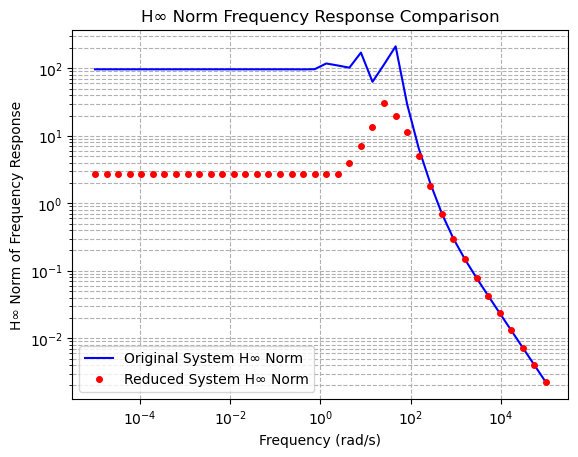

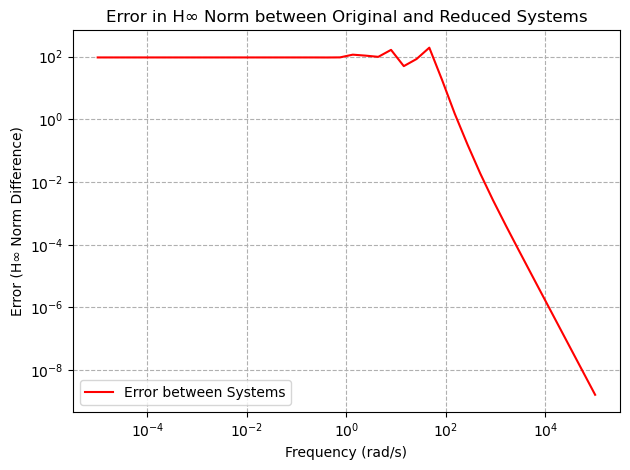

In [39]:
import numpy as np
from scipy.linalg import kron, eigh
from scipy.io import mmread
from numerical_test1 import fdm_matrix1
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import svds
from scipy.linalg import lu_factor, lu_solve, qr
from scipy.signal import lti
from global_requirement import global_qr, diamond_product
from numerical_test1 import fdm_matrix1
from scipy.linalg import solve
import matplotlib.pyplot as plt
from scipy import signal
from scipy.sparse.linalg import svds, LinearOperator, aslinearoperator
from scipy.sparse import eye, linalg as splinalg
import scipy.sparse as sps
from scipy.linalg import svdvals
from build_matrix_A import build_matrix_A
import time
from scipy.io import loadmat, whosmat
import scipy.io 

def global_arnoldi(A, B, m):
    n, p = B.shape  
    V = np.zeros((n, (m+1)*p))  
    H = np.zeros((m+1, m))  
    V[:, :p] = B / np.linalg.norm(B, 'fro')

    for j in range(m):
        Wj = A @ V[:, j*p:(j+1)*p]  
        for i in range(j+1):
            H_ij = V[:, i*p:(i+1)*p].T @ Wj
            h_ij = np.trace(H_ij)
            Wj = Wj - V[:, i*p:(i+1)*p] @ H_ij
            H[i, j] = h_ij
        h_j1j = np.linalg.norm(Wj, 'fro')
        if h_j1j != 0: 
            V[:, (j+1)*p:(j+2)*p] = Wj / h_j1j
            H[j+1, j] = h_j1j
        else:
            V = V[:, :(j+1)*p]  
            break

    return V[:, :m*p], H[:m,:m]

def model_reduction_global_arnoldi(A, B, C, m):
    Vm, Hm = global_arnoldi(A, B, m)

    _, p = B.shape
    Ip = np.eye(p)
    Am = np.kron(Hm, Ip)
    e1 = np.zeros((m,1))
    e1[0] = 1
    beta = np.linalg.norm(B, 'fro')
    Bm = beta * np.kron(e1, Ip)
    Cm = C @ Vm
    
    return Am, Bm, Cm

mat = scipy.io.loadmat('C:/Users/G-shop/Desktop/Benchmark Matrices/CDplayer.mat')
A = mat['A']
#B = mat['B']
#C = mat['C']

p=3
m=5
A = csr_matrix(A_matrix)
n, n = A.shape
B = np.random.uniform(0, 1, (n, p))
C = B.T

start_time = time.time()
Vm, Hm = global_arnoldi(A, B, m)
execution_time = time.time() - start_time
    
Am, Bm, Cm = model_reduction_global_arnoldi(A, B, C, m)
space_dimension = Am.shape[0]

print("Execution time:", execution_time)
print("Space dimension:", space_dimension)

frequencies = np.logspace(-5, 5, num=40)
response_original, response_reduced, error_responses_CGA = [], [], []

for omega in frequencies:
    s = 1j * omega
    sI_minus_A = csr_matrix(s * np.eye(A.shape[0]) - A)
    H_full = C @ spsolve(sI_minus_A, B)
    response_original.append(svds(H_full, k=1, which='LM', return_singular_vectors=False)[0])
    
    sI_minus_Am = s * np.eye(Am.shape[0]) - Am
    H_reduced = Cm @ spsolve(sI_minus_Am, Bm)
    response_reduced.append(svds(H_reduced, k=1, which='LM', return_singular_vectors=False)[0])
    
    error_responses_CGA.append(np.abs(response_original[-1] - response_reduced[-1]))

np.save('error_responses_CGA.npy', error_responses_CGA)
H_infinity_error = np.max(error_responses_CGA)
print("H∞ norm:", H_infinity_error)

figsize=(6, 4)
plt.subplot(1, 1, 1)

plt.loglog(frequencies, response_original, 'b-', label='Original System H∞ Norm')
plt.loglog(frequencies, response_reduced, 'ro', label='Reduced System H∞ Norm', markersize=4, linewidth=1) 
plt.xlabel('Frequency (rad/s)')
plt.ylabel('H∞ Norm of Frequency Response')
plt.title('H∞ Norm Frequency Response Comparison')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.savefig('C:/Users/G-shop/Desktop/RAPPORT-Master/hinf_norm_plot11.png')
plt.show()
plt.clf()

plt.subplot(1, 1, 1)
plt.loglog(frequencies, error_responses_CGA, 'r-', label='Error between Systems')
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Error (H∞ Norm Difference)')
plt.title('Error in H∞ Norm between Original and Reduced Systems')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.savefig('C:/Users/G-shop/Desktop/RAPPORT-Master/error_plot12.png')
plt.show()